# Part I. RUL prediction using Transformer model (Centralize model)

# Preparation

In [1]:
# When run code on Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
print(f'IN_COLAB: {IN_COLAB}')

IN_COLAB: False


In [2]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [3]:
# Off log duplicate messages
import os
os.environ["RAY_DEDUP_LOGS"] = "0"

# Off warning messages
import warnings
warnings.filterwarnings('ignore')

if not IN_COLAB:
    try:
        import pyinspect as pi
    except:
        pass

In [4]:
from collections import OrderedDict
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from datasets.utils.logging import disable_progress_bar

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
# from flwr_datasets import FederatedDataset

import shap

2025-02-11 07:51:20,062	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/os/anaconda3/envs/.venv/lib/python3.12/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):


In [5]:
# Check GPU if available else CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.14.0 / PyTorch 2.5.1+cu124


# Building Transformer model

In [6]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])
        return output.squeeze(-1)

# Building Dataloader

In [7]:
class CMAPSSLoaderDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []

        grouped = data.groupby('ID Engine')
        for _, group in grouped:
            values = group.drop(['ID Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3','Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values

            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length])
                self.targets.append(rul_values[i + sequence_length - 1])

    def __len__(self):

        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

# Define parameters for training

In [8]:
# Transformer parameters
input_dim = 21
d_model = 64
nhead = 4
num_layers = 2
dim_feedforward = 256
dropout = 0.1
learning_rate = 1e-3
verbose=False

# Dataloader parameters
sequence_length = 30

# Training parameters
batch_size = 128
epochs = 50

# Define training/test functions

In [9]:
def train_model(model, client_loader_train, client_loader_validation: None, epochs: int, learning_rate: int, verbose=False):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in client_loader_train:
            seq, target = batch
            seq, target = seq.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in client_loader_validation:
                seq, target = batch
                seq, target = seq.to(DEVICE), target.to(DEVICE)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(client_loader_train)}, Validation Loss: {val_loss/len(client_loader_validation)}")

In [10]:
def test_model(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()

    samples, targets = next(iter(client_loader_validation))
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for batch in client_loader_validation:
            samples, targets = batch
            samples, targets = samples.to(DEVICE), targets.to(DEVICE)
            predictions = model(samples)
            val_loss += criterion(predictions, targets).item()
    return val_loss/len(client_loader_validation)

# Define prediction functions

### Prediction on a batch

In [11]:
def predict_on_batch(model, batch_loader, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()
    samples, targets = batch_loader
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    model.eval()
    loss = 0
    with torch.no_grad():
        predictions = model(samples)
    loss = criterion(predictions, targets)

    if return_actual_rul:
        samples = samples.cpu()
        targets = targets.cpu()

        rul_min = scaler.data_min_[-1]
        rul_max = scaler.data_max_[-1]

        predictions = predictions.cpu()
        actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
        actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

        if show_fig:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
            plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
            plt.title("Comparison of Predicted and Actual RUL")
            plt.xlabel("Sample Index")
            plt.ylabel("Remaining Useful Life (RUL)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return loss, actual_predictions, actual_targets

    return loss

### Prediction on a sample

# File paths

In [12]:
if not IN_COLAB:
    train_1_path = "../data/train_FD001.txt"
    test_1_path = "../data/test_FD001.txt"
    rul_1_path = "../data/RUL_FD001.txt"

    train_2_path = "../data/train_FD002.txt"
    test_2_path = "../data/test_FD002.txt"
    rul_2_path = "../data/RUL_FD002.txt"

    train_3_path = "../data/train_FD003.txt"
    test_3_path = "../data/test_FD003.txt"
    rul_3_path = "../data/RUL_FD003.txt"

    train_4_path = "../data/train_FD004.txt"
    test_4_path = "../data/test_FD004.txt"
    rul_4_path = "../data/RUL_FD004.txt"
    
elif IN_COLAB:
    train_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD001.txt"
    test_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD001.txt"
    rul_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD001.txt"

    train_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD002.txt"
    test_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD002.txt"
    rul_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD002.txt"

    train_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD003.txt"
    test_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD003.txt"
    rul_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD003.txt"

    train_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD004.txt"
    test_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD004.txt"
    rul_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD004.txt"

In [13]:
# Initialization columns
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

# Calculate RUL for FD001

### Calculate RUL for train set

In [14]:
# Load trainset
train_1 = pd.read_csv(train_1_path, sep=' ', header=None)
train_1.drop([26, 27], axis=1, inplace=True)
train_1.columns = column_names

train_1['Remaining RUL'] = ''
# train_1.head()

In [15]:
# Calculate the remaining RUL for each engine
max_cycle_1 = train_1.groupby('ID Engine').count()
for idx in range(len(train_1)):
    train_1.loc[idx, 'Remaining RUL'] = max_cycle_1.loc[train_1.loc[idx, 'ID Engine'], 'Cycle']
train_1['Remaining RUL'] = train_1['Remaining RUL'] - train_1['Cycle']

print(f"trainset shape: {train_1.shape}")

trainset shape: (20631, 27)


In [16]:
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### Load RUL set

In [17]:
rul_1 = pd.read_csv(rul_1_path, sep=' ', header=None)
rul_1.drop(rul_1.columns[1], axis=1, inplace=True)
rul_1.columns = ['RUL']
print(f'RUL shape: {rul_1.shape}')

RUL shape: (100, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [18]:
rul_1.head()

,RUL
0,112
1,98
2,69
3,82
4,91


### Calculate RUL for test

In [19]:
# Load test set
test_1 = pd.read_csv(test_1_path, sep=' ', header=None)
test_1.drop([26, 27], axis=1, inplace=True)
test_1.columns = column_names

test_1['Remaining RUL'] = ''
# test_1.head()

In [20]:
max_cycle_test_1 = test_1.groupby('ID Engine').count()

for idx in range(len(test_1)):
    test_1.loc[idx, 'Remaining RUL'] = rul_1.loc[test_1.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_1.loc[test_1.loc[idx, 'ID Engine'], 'Cycle']
test_1['Remaining RUL'] = test_1['Remaining RUL'] - test_1['Cycle']

In [21]:
test_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


# Calculate RUL for FD002

### Calculate RUL for train set

In [22]:
# Load trainset
train_2 = pd.read_csv(train_2_path, sep=' ', header=None)
train_2.drop([26, 27], axis=1, inplace=True)
train_2.columns = column_names

train_2['Remaining RUL'] = ''
# train_2.head()

In [23]:
# Calculate the remaining RUL for each engine
max_cycle_2 = train_2.groupby('ID Engine').count()
for idx in range(len(train_2)):
    train_2.loc[idx, 'Remaining RUL'] = max_cycle_2.loc[train_2.loc[idx, 'ID Engine'], 'Cycle']
train_2['Remaining RUL'] = train_2['Remaining RUL'] - train_2['Cycle']

print(f"trainset shape: {train_2.shape}")

trainset shape: (53759, 27)


In [24]:
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


### Load RUL set

In [25]:
rul_2 = pd.read_csv(rul_2_path, sep=' ', header=None)
rul_2.drop(rul_2.columns[1], axis=1, inplace=True)
rul_2.columns = ['RUL']
print(f'RUL shape: {rul_2.shape}')

RUL shape: (259, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [26]:
rul_2.head()

,RUL
0,18
1,79
2,106
3,110
4,15


### Calculate RUL for test

In [27]:
# Load test set
test_2 = pd.read_csv(test_2_path, sep=' ', header=None)
test_2.drop([26, 27], axis=1, inplace=True)
test_2.columns = column_names

test_2['Remaining RUL'] = ''
# test_2.head()

In [28]:
max_cycle_test_2 = test_2.groupby('ID Engine').count()

for idx in range(len(test_2)):
    test_2.loc[idx, 'Remaining RUL'] = rul_2.loc[test_2.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_2.loc[test_2.loc[idx, 'ID Engine'], 'Cycle']
test_2['Remaining RUL'] = test_2['Remaining RUL'] - test_2['Cycle']

In [29]:
test_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,275
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,274
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,273
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,272
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,271


# Calculate RUL for FD003

### Calculate RUL for train set

In [30]:
# Load trainset
train_3 = pd.read_csv(train_3_path, sep=' ', header=None)
train_3.drop([26, 27], axis=1, inplace=True)
train_3.columns = column_names

train_3['Remaining RUL'] = ''
# train_3.head()

In [31]:
# Calculate the remaining RUL for each engine
max_cycle_3 = train_3.groupby('ID Engine').count()
for idx in range(len(train_3)):
    train_3.loc[idx, 'Remaining RUL'] = max_cycle_3.loc[train_3.loc[idx, 'ID Engine'], 'Cycle']
train_3['Remaining RUL'] = train_3['Remaining RUL'] - train_3['Cycle']

print(f"trainset shape: {train_3.shape}")

trainset shape: (24720, 27)


In [32]:
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


### Load RUL set

In [33]:
rul_3 = pd.read_csv(rul_3_path, sep=' ', header=None)
rul_3.drop(rul_3.columns[1], axis=1, inplace=True)
rul_3.columns = ['RUL']
print(f'RUL shape: {rul_3.shape}')

RUL shape: (100, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [34]:
rul_3.head()

,RUL
0,44
1,51
2,27
3,120
4,101


### Calculate RUL for test

In [35]:
# Load test set
test_3 = pd.read_csv(test_3_path, sep=' ', header=None)
test_3.drop([26, 27], axis=1, inplace=True)
test_3.columns = column_names

test_3['Remaining RUL'] = ''
# test_3.head()

In [36]:
max_cycle_test_3 = test_3.groupby('ID Engine').count()

for idx in range(len(test_3)):
    test_3.loc[idx, 'Remaining RUL'] = rul_3.loc[test_3.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_3.loc[test_3.loc[idx, 'ID Engine'], 'Cycle']
test_3['Remaining RUL'] = test_3['Remaining RUL'] - test_3['Cycle']

In [37]:
test_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,276
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,275
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,274
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,273
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,272


# Calculate RUL for FD004

### Calculate RUL for train set

In [38]:
# Load trainset
train_4 = pd.read_csv(train_4_path, sep=' ', header=None)
train_4.drop([26, 27], axis=1, inplace=True)
train_4.columns = column_names

train_4['Remaining RUL'] = ''
# train_4.head()

In [39]:
# Calculate the remaining RUL for each engine
max_cycle_4 = train_4.groupby('ID Engine').count()
for idx in range(len(train_4)):
    train_4.loc[idx, 'Remaining RUL'] = max_cycle_4.loc[train_4.loc[idx, 'ID Engine'], 'Cycle']
train_4['Remaining RUL'] = train_4['Remaining RUL'] - train_4['Cycle']

print(f"trainset shape: {train_4.shape}")

trainset shape: (61249, 27)


In [40]:
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


### Load RUL set

In [41]:
rul_4 = pd.read_csv(rul_4_path, sep=' ', header=None)
rul_4.drop(rul_4.columns[1], axis=1, inplace=True)
rul_4.columns = ['RUL']
print(f'RUL shape: {rul_4.shape}')

RUL shape: (248, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [42]:
rul_4.head()

,RUL
0,22
1,39
2,107
3,75
4,149


### Calculate RUL for test

In [43]:
# Load test set
test_4 = pd.read_csv(test_4_path, sep=' ', header=None)
test_4.drop([26, 27], axis=1, inplace=True)
test_4.columns = column_names

test_4['Remaining RUL'] = ''
# test_4.head()

In [44]:
max_cycle_test_4 = test_4.groupby('ID Engine').count()

for idx in range(len(test_4)):
    test_4.loc[idx, 'Remaining RUL'] = rul_4.loc[test_4.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_4.loc[test_4.loc[idx, 'ID Engine'], 'Cycle']
test_4['Remaining RUL'] = test_4['Remaining RUL'] - test_4['Cycle']

In [45]:
test_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,247


# Plot number of sample for each dataset

In [46]:
len(train_1)

20631

In [47]:
len(train_2)

53759

In [48]:
len(train_3)

24720

In [49]:
len(train_4)

61249

In [50]:
total = len(train_1) + len(train_2) + len(train_3) + len(train_4)
total

160359

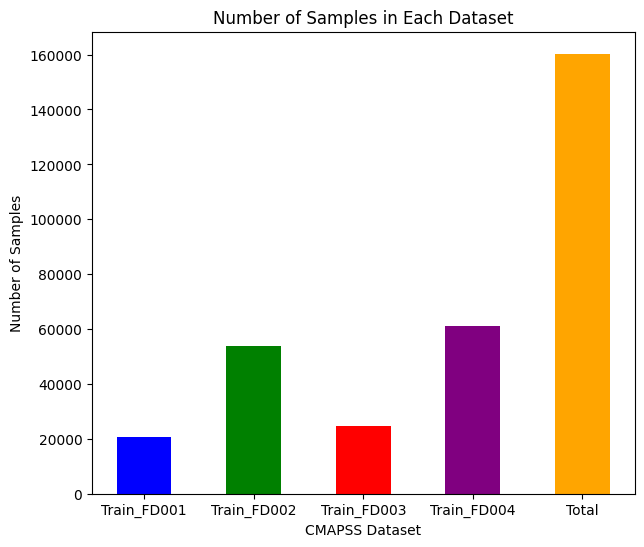

In [51]:
sample_counts = [len(train_1), len(train_2), len(train_3), len(train_4), total]
labels = ['Train_FD001', 'Train_FD002', 'Train_FD003', 'Train_FD004', 'Total']

plt.figure(figsize=(7, 6))
plt.bar(labels, sample_counts, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)
plt.xlabel('CMAPSS Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Dataset')
plt.show()

# Concatenate for train_FD001,2,3,4

In [52]:
print(f'train_1 shape: {train_1.shape}')
print(f'test_1 shape: {test_1.shape}')
print(f'rul_1 shape: {rul_1.shape}')
print(f'max_cycle_1 shape: {max_cycle_1.shape}')

train_1 shape: (20631, 27)
test_1 shape: (13096, 27)
rul_1 shape: (100, 1)
max_cycle_1 shape: (100, 26)


In [53]:
print(f'train_2 shape: {train_2.shape}')
print(f'test_2 shape: {test_2.shape}')
print(f'rul_2 shape: {rul_2.shape}')
print(f'max_cycle_2 shape: {max_cycle_2.shape}')

train_2 shape: (53759, 27)
test_2 shape: (33991, 27)
rul_2 shape: (259, 1)
max_cycle_2 shape: (260, 26)


In [54]:
print(f'train_3 shape: {train_3.shape}')
print(f'test_3 shape: {test_3.shape}')
print(f'rul_3 shape: {rul_3.shape}')
print(f'max_cycle_3 shape: {max_cycle_3.shape}')

train_3 shape: (24720, 27)
test_3 shape: (16596, 27)
rul_3 shape: (100, 1)
max_cycle_3 shape: (100, 26)


In [55]:
print(f'train_4 shape: {train_4.shape}')
print(f'test_4 shape: {test_4.shape}')
print(f'rul_4 shape: {rul_4.shape}')
print(f'max_cycle_4 shape: {max_cycle_4.shape}')

train_4 shape: (61249, 27)
test_4 shape: (41214, 27)
rul_4 shape: (248, 1)
max_cycle_4 shape: (249, 26)


In [56]:
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [57]:
num = len(train_1)
for idx in range(len(train_2)):
    train_2.loc[idx, 'ID Engine'] += num
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,20632,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,20632,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,20632,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,20632,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,20632,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [58]:
num += len(train_2)
for idx in range(len(train_3)):
    train_3.loc[idx, 'ID Engine'] += num
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,74391,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,74391,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,74391,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,74391,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,74391,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [59]:
num += len(train_3)
for idx in range(len(train_4)):
    train_4.loc[idx, 'ID Engine'] += num
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,99111,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,99111,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,99111,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,99111,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,99111,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [60]:
train = pd.concat([train_1, train_2, train_3, train_4], ignore_index=True)
print(f'Train shape: {train.shape}')
train.head()

Train shape: (160359, 27)


,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


# Standard data (for train and test set)

In [61]:
scaled_columns = train.columns[5:]
scaler = MinMaxScaler()
train[scaled_columns] = scaler.fit_transform(train[scaled_columns])
# test[scaled_columns] = scaler.fit_transform(test[scaled_columns])

In [62]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,1.0,0.969990,0.927293,0.902111,1.0,...,0.993194,0.653748,0.090428,1.0,0.918367,1.0,1.0,0.972082,0.970373,0.352399
1,1,2,0.0019,-0.0003,100.0,1.0,0.973000,0.932957,0.908192,1.0,...,0.993332,0.637831,0.094654,1.0,0.918367,1.0,1.0,0.970064,0.970630,0.350554
2,1,3,-0.0043,0.0003,100.0,1.0,0.974824,0.922723,0.910730,1.0,...,0.993222,0.641715,0.089844,1.0,0.897959,1.0,1.0,0.968382,0.966204,0.348708
3,1,4,0.0007,0.0000,100.0,1.0,0.974824,0.908829,0.905152,1.0,...,0.993359,0.643055,0.072803,1.0,0.918367,1.0,1.0,0.966028,0.967860,0.346863
4,1,5,-0.0019,-0.0002,100.0,1.0,0.975007,0.908989,0.915565,1.0,...,0.993249,0.642988,0.093829,1.0,0.928571,1.0,1.0,0.966700,0.969560,0.345018


In [63]:
# test.head()

### Load data into DataLoader

In [64]:
data_train = CMAPSSLoaderDataset(data=train, sequence_length=1)
# data_test = CMAPSSLoaderDataset(data=test, sequence_length=sequence_length)

data_train, data_validation = train_test_split(data_train, test_size=0.2, random_state=42)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(data_validation, batch_size=batch_size, shuffle=True)

In [65]:
data_train[1][0]

tensor([[0.0000, 0.1262, 0.2916, 0.2269, 0.0000, 0.0025, 0.0077, 0.6272, 0.2661,
         0.2308, 0.4580, 0.0050, 0.9932, 0.5372, 0.4003, 0.0000, 0.2857, 0.6279,
         1.0000, 0.0195, 0.0202]])

In [ ]:
data_train[1][1]

tensor(0.4613)

# Training with sequence_length = 30

### Load data into DataLoader

In [67]:
data_train = CMAPSSLoaderDataset(data=train, sequence_length=sequence_length)
# data_test = CMAPSSLoaderDataset(data=test, sequence_length=sequence_length)

data_train, data_validation = train_test_split(data_train, test_size=0.2, random_state=42)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(data_validation, batch_size=batch_size, shuffle=True)

In [68]:
data_train.__len__()

111838

In [69]:
data_validation.__len__()

27960

In [70]:
train_loader.__len__()

874

In [71]:
validation_loader.__len__()

219

### Training centralize model

In [72]:
centralize_transformer_model = TransformerModel(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=256,
    dropout=dropout
)

In [73]:
try:
    train_model(
        model=centralize_transformer_model,
        client_loader_train=train_loader,
        client_loader_validation=validation_loader,
        # epochs=1,
        epochs=epochs,
        learning_rate=learning_rate,
        verbose=False
    )
except KeyboardInterrupt:
    print("Training interrupted")

Epoch 1/50, Train Loss: 0.02972416396229368, Validation Loss: 0.021792468193867435
Epoch 2/50, Train Loss: 0.019630404848827037, Validation Loss: 0.01027991227193238
Epoch 3/50, Train Loss: 0.010602225263941887, Validation Loss: 0.00980975339827064
Epoch 4/50, Train Loss: 0.009889126015780174, Validation Loss: 0.00871522781400852
Epoch 5/50, Train Loss: 0.009577082956499618, Validation Loss: 0.008658670239813933
Epoch 6/50, Train Loss: 0.009378468358859386, Validation Loss: 0.008983324084124744
Epoch 7/50, Train Loss: 0.009417596349846444, Validation Loss: 0.008899918357633292
Epoch 8/50, Train Loss: 0.00928932538488347, Validation Loss: 0.009043507116366195
Epoch 9/50, Train Loss: 0.009151406255838391, Validation Loss: 0.009603619892320269
Epoch 10/50, Train Loss: 0.009219406224846908, Validation Loss: 0.009449454396537858
Epoch 11/50, Train Loss: 0.009145454043795267, Validation Loss: 0.008505226342543347
Epoch 12/50, Train Loss: 0.008984394804670452, Validation Loss: 0.0084964115933

### Predict on batch (Centralize model)

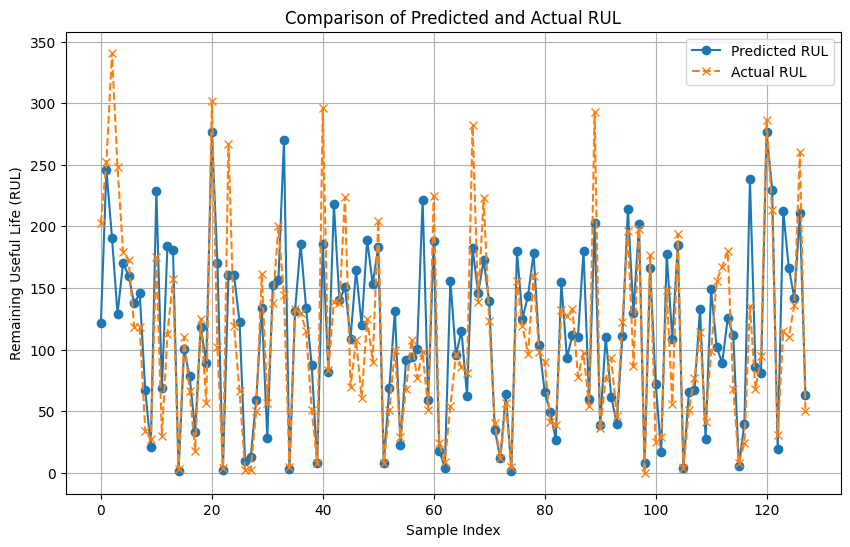

Loss on random batch: 0.007057718932628632


In [74]:
batch_loader = next(iter(validation_loader))

loss, _, _ = predict_on_batch(
    model=centralize_transformer_model,
    batch_loader=batch_loader,
    return_actual_rul=True,
    show_fig=True,
)
print(f'Loss on random batch: {loss}')

# Part II. Explainable Artificial Intelligence for RUL forecasting using Transformer model

In [ ]:
# import shap
# sequence_length = 30
# feature_dim = 21
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Dữ liệu nền và dữ liệu cần giải thích
# background_data, _ = next(iter(validation_loader))
# background_data_np = background_data.cpu().numpy()  # (batch_size, seq_len, feature_dim)
# data_to_explain = background_data_np[:10]           # Chọn 10 mẫu để giải thích

# # Chuyển đổi dữ liệu nền và dữ liệu cần giải thích thành dạng 2D
# background_data_2d = background_data_np.reshape(background_data_np.shape[0], -1)  # (batch_size, seq_len * feature_dim)
# data_to_explain_2d = data_to_explain.reshape(data_to_explain.shape[0], -1)        #
# # Sử dụng DeepExplainer thay vì KernelExplainer
# explainer = shap.DeepExplainer(centralize_transformer_model, background_data)

# # Tính SHAP values
# shap_values = explainer.shap_values(data_to_explain)

# # Chuyển SHAP values về dạng 3D (num_samples, seq_len, feature_dim)
# shap_values_array = np.array(shap_values).reshape(data_to_explain.shape[0], sequence_length, feature_dim)  # (10, seq_len, feature_dim)

# # Các biểu đồ XAI sẽ được tính như bình thường sau đó


# Part III. Setup Federated Learning with Flower for RUL prediction using Transformer model

### Define parameters for training FL with Flower

In [76]:
num_clients = 10
num_rounds = 50

### Split dataframe to 10 subframe for 10 client

In [77]:
def split_dataset(dataset, num_clients):
    """
    Chia dataset thành num_clients tập con đều nhau.
    Args:
        dataset: Dataset cần chia (torch.utils.data.Dataset).
        num_clients: Số lượng tập con muốn tạo.
    Returns:
        List chứa các tập con của dataset.
    """
    # Kích thước mỗi tập con
    subset_size = len(dataset) // num_clients
    sizes = [subset_size] * num_clients

    # Chia phần dư (nếu tổng dataset không chia hết)
    sizes[-1] += len(dataset) - sum(sizes)

    # Tạo danh sách các tập con
    subsets = random_split(dataset, sizes)
    return subsets

In [78]:
# train.head()
train.shape

(160359, 27)

In [79]:
data = CMAPSSLoaderDataset(train, sequence_length=sequence_length)
train_data, validation_data = train_test_split(data, test_size=0.2, random_state=42)

subset_trains = split_dataset(train_data, num_clients=num_clients)
subset_validations = split_dataset(validation_data, num_clients=num_clients)

client_loader_trains = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subset_trains]
client_loader_validations = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subset_validations]

In [80]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")

Client 1 will use a subset with 11183 samples
Client 2 will use a subset with 11183 samples
Client 3 will use a subset with 11183 samples
Client 4 will use a subset with 11183 samples
Client 5 will use a subset with 11183 samples
Client 6 will use a subset with 11183 samples
Client 7 will use a subset with 11183 samples
Client 8 will use a subset with 11183 samples
Client 9 will use a subset with 11183 samples
Client 10 will use a subset with 11191 samples


In [81]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")

Client 1 will use a subset with 11183 samples
Client 2 will use a subset with 11183 samples
Client 3 will use a subset with 11183 samples
Client 4 will use a subset with 11183 samples
Client 5 will use a subset with 11183 samples
Client 6 will use a subset with 11183 samples
Client 7 will use a subset with 11183 samples
Client 8 will use a subset with 11183 samples
Client 9 will use a subset with 11183 samples
Client 10 will use a subset with 11191 samples


### Update model parameters

In [82]:
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

### Define the Flower ClientApp

In [83]:
class FlowerClient(NumPyClient):
    def __init__(self, model, client_loader_train, client_loader_validation):
        self.model = model
        self.trainloader = client_loader_train
        self.valloader = client_loader_validation

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        train_model(
            model=self.model,
            client_loader_train=self.trainloader,
            client_loader_validation=self.valloader,
            epochs=1,
            learning_rate=learning_rate,
            verbose=False
        )
        return get_parameters(self.model), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        # loss, accuracy = test(self.model, self.valloader)
        loss = test_model(
            model=self.model,
            client_loader_validation=self.valloader,
            return_actual_rul=False,
            show_fig=False
        )
        return float(loss), len(self.valloader), {"accuracy": float(0.0)}

In [84]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    model = TransformerModel(
        input_dim=input_dim,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=0.1
    ).to(DEVICE)

    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader = client_loader_trains[partition_id]
    valloader = client_loader_validations[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

### Define the Flower ServerApp

In [85]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [86]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=50)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

### Run the training

In [87]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [88]:
try:
    # Run simulation
    run_simulation(
        server_app=server,
        client_app=client,
        num_supernodes=num_clients,
        backend_config=backend_config
    )
except KeyboardInterrupt:
    print("Simulation interrupted by user.")

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout


INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.14230453796600076, Validation Loss: 0.01969371507452293
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.13725887177596716, Validation Loss: 0.02065573933280327
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.13487812006761404, Validation Loss: 0.020625975998965176
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.1331858519803394, Validation Loss: 0.020816914991221645
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.14138958855024117, Validation Loss: 0.020497645759447056
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.1366643693975427, Validation Loss: 0.020275124814361334
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.13471100009469825, Validation Loss: 0.021388838956640524
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.13529237429611385, Validation Loss: 0.021371785762973806
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.13496110967191105, Validation Loss: 0.02132272618738088


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.14018663865598766, Validation Loss: 0.019162043929100037


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.031177376481619747, Validation Loss: 0.02034576347267086
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.03290078189985996, Validation Loss: 0.020418942694298246
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.032670758008448916, Validation Loss: 0.020143419165502895
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.03446332024495033, Validation Loss: 0.020757740109481594
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02870921246622774, Validation Loss: 0.023419508879834957
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02861490494317629, Validation Loss: 0.021023908122019333
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.03321689839305526, Validation Loss: 0.021721186285669155
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.03299590056254105, Validation Loss: 0.021262461150234394
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.030518322336402805, Validation Loss: 0.021925893527540295


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.03116800801151178, Validation Loss: 0.020302928349172526


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02443666502156041, Validation Loss: 0.019375993065874685
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02284708198964257, Validation Loss: 0.020366812717508186
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.023125139488415283, Validation Loss: 0.021038286218589
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.023803675737739963, Validation Loss: 0.020805491981181232
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.023141839530911635, Validation Loss: 0.02030854697593234
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02379041931337931, Validation Loss: 0.020421023776924067
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.023815001477487385, Validation Loss: 0.021529444324021988
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.023509386567060243, Validation Loss: 0.023143621415577152
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.024573852816088634, Validation Loss: 0.021933475593951614


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.025193902748552235, Validation Loss: 0.02005832523784854


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.022414514202285896, Validation Loss: 0.01938384949144992
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021804047155786644, Validation Loss: 0.022260203449563545
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02261615265160799, Validation Loss: 0.02013222509148446
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021793507357043298, Validation Loss: 0.02073723975230347
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.022470728113231333, Validation Loss: 0.02038918782702901
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.022250673500820994, Validation Loss: 0.02024601357565685
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.022188478699800642, Validation Loss: 0.02237671503627842
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.022321742535992103, Validation Loss: 0.021214594895189457
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021934503922238946, Validation Loss: 0.021503237076103687


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02307930951726369, Validation Loss: 0.020459314977580852


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021948332464407114, Validation Loss: 0.020405791615220634
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021478830540383406, Validation Loss: 0.020405402322384445
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021699825280599973, Validation Loss: 0.020185541149906137
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02148810241752389, Validation Loss: 0.02131867806681178
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02128207195677202, Validation Loss: 0.020258472301065922
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021130804501643233, Validation Loss: 0.02025988469408317
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02132508240174502, Validation Loss: 0.023385086012157528
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021479460749436508, Validation Loss: 0.021949227052656086
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021938981488347054, Validation Loss: 0.0214195383543318


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.022393869479525496, Validation Loss: 0.020634648051451553


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.020203473744913936, Validation Loss: 0.019230252809145233
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.020122389287941835, Validation Loss: 0.015303000723096457
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021074237503026696, Validation Loss: 0.02045318420807069
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.019914833606559445, Validation Loss: 0.019353377251801165
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.020810019510628826, Validation Loss: 0.021046623672274025
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.021378301179290495, Validation Loss: 0.020744748836891216
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02056715153792704, Validation Loss: 0.019433325706896456
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.020905962203290652, Validation Loss: 0.019981492564759472
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.020668001856062223, Validation Loss: 0.019466054456477814


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.02109482811382887, Validation Loss: 0.017633500635962595


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01896141292738982, Validation Loss: 0.016124553555114704
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.017194923690774223, Validation Loss: 0.01533070346340537
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.016393336837857285, Validation Loss: 0.01259635981510986
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01711273951117288, Validation Loss: 0.01733356091955846
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01770433536942371, Validation Loss: 0.012915222439914942
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01779921069233255, Validation Loss: 0.014657521281730045
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.016345324121754278, Validation Loss: 0.01624040381813591
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01888613289603117, Validation Loss: 0.015601208052513275
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.017571384087204933, Validation Loss: 0.019484720573845236


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01711756250270727, Validation Loss: 0.01138631838627837


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.015605896224521777, Validation Loss: 0.015026230788366362
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01453976650637659, Validation Loss: 0.01239938610656695
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.013957732600498606, Validation Loss: 0.011086605954915285
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.013841991111720827, Validation Loss: 0.012382590592923489
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.014695546293461864, Validation Loss: 0.011242086067795753
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.013384257337417115, Validation Loss: 0.011004052209583197
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.014079037778587504, Validation Loss: 0.013381893788887695
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.016018678233112125, Validation Loss: 0.011867786757647991
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.015048955239101568, Validation Loss: 0.016031529077074745


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.015397441658106718, Validation Loss: 0.010741420682858337


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.013334322911263867, Validation Loss: 0.011774995025585999
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.013206994690170342, Validation Loss: 0.011997298506850546
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.012643643400885841, Validation Loss: 0.009966266743669456
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.012698578108525411, Validation Loss: 0.010745873420753262
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.012450641074048524, Validation Loss: 0.011344868986105377
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.012515995344570414, Validation Loss: 0.010433485900813883
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.012690235516691411, Validation Loss: 0.012519434560090303
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.013076724860266868, Validation Loss: 0.011177025841210376
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.0128387935269116, Validation Loss: 0.011110761329870333


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.013121671773577955, Validation Loss: 0.009859296323900873


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.012074007282287559, Validation Loss: 0.009326999943534081
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011847906872968782, Validation Loss: 0.010454426329074935
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011652913357300515, Validation Loss: 0.010313814209604805
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011508551696103743, Validation Loss: 0.010304766389625993
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.012085169326217676, Validation Loss: 0.009728819512846794
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.012155685753730888, Validation Loss: 0.010763444514437155
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011383451473772187, Validation Loss: 0.010406402998011221
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01158309145301411, Validation Loss: 0.011057476470754906
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.012247182291255078, Validation Loss: 0.0099624903364615


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.012080338804728606, Validation Loss: 0.009987311670556664


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011952115614390508, Validation Loss: 0.008845456706529314
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01129335729108954, Validation Loss: 0.008946982360529628
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010949664082462814, Validation Loss: 0.009817768523300236
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011416656187396835, Validation Loss: 0.009178670356050134
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011204858733849092, Validation Loss: 0.00977986511266367
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010814894551665268, Validation Loss: 0.010120696938512001
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011626904306467623, Validation Loss: 0.00946414633654058
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01121539535233751, Validation Loss: 0.01051290337504311
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01102353092706339, Validation Loss: 0.010468461296775124


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011336909474762664, Validation Loss: 0.009398922408846292


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011079869264821436, Validation Loss: 0.010281594935804605
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010671460286671803, Validation Loss: 0.009677845709533854
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011038040509447455, Validation Loss: 0.009162113430317153
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010921406009319153, Validation Loss: 0.012109449260275473
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01082472613779828, Validation Loss: 0.010008295257152482
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010904289411634883, Validation Loss: 0.010610231939195231
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010980204557364976, Validation Loss: 0.009885963475839659
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010607125084127554, Validation Loss: 0.01114936617457054
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010733846702020277, Validation Loss: 0.010369265706024387


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.011530741927510297, Validation Loss: 0.008827416776594791


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010537113660988822, Validation Loss: 0.010620132257992571
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010477161045524885, Validation Loss: 0.00918722891418094
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01053812130968171, Validation Loss: 0.010749255180020224
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010643071928908203, Validation Loss: 0.009923068467866291
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010950213790320877, Validation Loss: 0.01091491464864124
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010775179602205753, Validation Loss: 0.01083905745128339
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010540418956555764, Validation Loss: 0.010715042071586306
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010493826084050605, Validation Loss: 0.009762618690729141
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010705312724563886, Validation Loss: 0.009642863836647435


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010857144783420319, Validation Loss: 0.008787848648022522


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010581851603505625, Validation Loss: 0.008949295956302773
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010599107751411131, Validation Loss: 0.009732100964439187
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010374430932146921, Validation Loss: 0.009131030602888628
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010394483963450924, Validation Loss: 0.010148809397254478
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010496771142987365, Validation Loss: 0.009843677557496862
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010619310545735061, Validation Loss: 0.00968877619809725
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010341339384798299, Validation Loss: 0.010115022982724688
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010302825846751644, Validation Loss: 0.010051988467404788
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010275093732740392, Validation Loss: 0.009483861080794171


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010675909611481156, Validation Loss: 0.008561804763634096


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010400555498728698, Validation Loss: 0.008758995406837626
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01062884921504354, Validation Loss: 0.010434552815488794
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010312099210833285, Validation Loss: 0.008888287109915505
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010442989391528747, Validation Loss: 0.009346396810459819
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010219161197627809, Validation Loss: 0.009169114033945581
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010114683589728718, Validation Loss: 0.009098289534449577
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01020345607751303, Validation Loss: 0.009750400839204138
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010063970895399425, Validation Loss: 0.011712591460143978
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01033016933996061, Validation Loss: 0.011043683138929984


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010764808547471395, Validation Loss: 0.010123637250878594


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01032304095464166, Validation Loss: 0.01010028924793005
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010303957731759345, Validation Loss: 0.00940432416444475
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010341695726806805, Validation Loss: 0.00939712059599432
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009967105812393129, Validation Loss: 0.008765329733829607
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010320897060658106, Validation Loss: 0.00962799607606774
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010011257968885317, Validation Loss: 0.010794183578003536
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010134020740885964, Validation Loss: 0.00922425288114358
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010156584321521223, Validation Loss: 0.009094886735758999
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010557937875009056, Validation Loss: 0.00993420037610287


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010624358187090944, Validation Loss: 0.008742130911824379


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010352372816255824, Validation Loss: 0.00963398361239921
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010184990427329798, Validation Loss: 0.009248194496401331
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010061897305687044, Validation Loss: 0.009790622967888008
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010220327134117146, Validation Loss: 0.009276157181540673
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009839355485217477, Validation Loss: 0.009656666778028011
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010234672713770786, Validation Loss: 0.008757396452975545
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010247069125233049, Validation Loss: 0.009632849790663882
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010077108300968328, Validation Loss: 0.009690028869292953
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010483598897487602, Validation Loss: 0.009335010164332662


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010717010617637161, Validation Loss: 0.008690813323482871


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010104130260350013, Validation Loss: 0.008807263167744333
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010152009982531044, Validation Loss: 0.009096468396654183
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010044954965864732, Validation Loss: 0.009435699617659504
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01027676003286615, Validation Loss: 0.00961281683041968
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01004215450534089, Validation Loss: 0.009232050188901749
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010203551030082797, Validation Loss: 0.008533097676594149
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010015583650039678, Validation Loss: 0.009628927504474466
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010024095774331892, Validation Loss: 0.009273687758567658
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010115312470588833, Validation Loss: 0.015165987932546572


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010181143398354338, Validation Loss: 0.009387283776463433


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010295824285342613, Validation Loss: 0.009514104532585903
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010090499089776793, Validation Loss: 0.009110406930135055
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009866666128139266, Validation Loss: 0.008782405998896469
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010006632417736744, Validation Loss: 0.011217831210656599
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01018640454541045, Validation Loss: 0.009418318534947255
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010017387727698819, Validation Loss: 0.008707552576776256
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010055347578600049, Validation Loss: 0.009389521342448214
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01007106438787146, Validation Loss: 0.009245230329476974
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010096444457303733, Validation Loss: 0.009551194581118498


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010468436711975797, Validation Loss: 0.008510728070343082


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01019891837230799, Validation Loss: 0.009172022596678951
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010248828647573564, Validation Loss: 0.010314610744403168
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00980626841456714, Validation Loss: 0.009157018863003363
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009718109070408073, Validation Loss: 0.010028087089515546
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009980301071085374, Validation Loss: 0.00940530042333359
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009977570978331973, Validation Loss: 0.008721884594044903
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009917872349350628, Validation Loss: 0.009485339576547796
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01008029156681997, Validation Loss: 0.00966072247617624
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009742118682796981, Validation Loss: 0.010618213161995465


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010247194134122268, Validation Loss: 0.008500366323542867


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009895338211208582, Validation Loss: 0.008678643392737617
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009924660569099202, Validation Loss: 0.009254604959013786
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009636563227765939, Validation Loss: 0.009957063773816282
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009814359750387004, Validation Loss: 0.009226085850968957
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010040242193182084, Validation Loss: 0.010003310014409099
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009944199552674863, Validation Loss: 0.00909570039419288
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009912678072313693, Validation Loss: 0.00948093319311738
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00987372855359519, Validation Loss: 0.008918721123005856
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009871448522475972, Validation Loss: 0.010405605616555973


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010716244080950591, Validation Loss: 0.010290570641783152


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009885973302351142, Validation Loss: 0.008553918853232806
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009920860899993304, Validation Loss: 0.00905503592961891
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009917651848147878, Validation Loss: 0.009475981689650904
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009933228625661948, Validation Loss: 0.008974495576694608
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00966043573465537, Validation Loss: 0.00913685979321599
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009786547590258786, Validation Loss: 0.008600998183035037
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010100035764149983, Validation Loss: 0.00950618503107266
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010146173585036939, Validation Loss: 0.009986558696255088
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00964680541603064, Validation Loss: 0.009511191524903883


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010361415693875064, Validation Loss: 0.008743353145705028


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009915649181824516, Validation Loss: 0.011044231920757076
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.0097374633081596, Validation Loss: 0.009428811682896181
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009911820678760043, Validation Loss: 0.009185319533571601
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009823888614350422, Validation Loss: 0.00892935471016575
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009612745711241256, Validation Loss: 0.009251476731151342
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009722173917742277, Validation Loss: 0.008719110438092188
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009622166134332392, Validation Loss: 0.010344297921454365
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00952909801112996, Validation Loss: 0.00894040502184494
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010028068182608959, Validation Loss: 0.009463290514593775


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010120311154010282, Validation Loss: 0.00839139711619778


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009762863734398376, Validation Loss: 0.008552957559004426
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009809235809370875, Validation Loss: 0.009463042994453148
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009732672018633986, Validation Loss: 0.00836998304690827
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009727500860621645, Validation Loss: 0.008760600117966533
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009506426635198295, Validation Loss: 0.008954961043359204
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00973617733689025, Validation Loss: 0.009681286734782836
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009828980456487361, Validation Loss: 0.008951619161631574
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009472496627660637, Validation Loss: 0.008953537008809772
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009702848810279234, Validation Loss: 0.009566048964519392


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010122400830203498, Validation Loss: 0.008212942439554767


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009966538382948122, Validation Loss: 0.009252562187612057
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009697470332453535, Validation Loss: 0.009000675181265582
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009868177553554151, Validation Loss: 0.008469523227011616
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009796302178239619, Validation Loss: 0.008565749359232459
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009558872875376519, Validation Loss: 0.009424558967690577
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009699773614887486, Validation Loss: 0.008423366075889631
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009550929598679597, Validation Loss: 0.010053130734542554
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009469470379620114, Validation Loss: 0.009329891721294685
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009689328414176336, Validation Loss: 0.009363179031590169


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.01003735718867657, Validation Loss: 0.008200671333311633


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.0099401894046671, Validation Loss: 0.009691415608606556
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009971134840849449, Validation Loss: 0.008517593378201127
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009749015660914169, Validation Loss: 0.009480613431977954
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009679306055080484, Validation Loss: 0.009484902638095346
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009958477992437442, Validation Loss: 0.008981432638723742
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009706259101883254, Validation Loss: 0.009186377516016364
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009457560314331204, Validation Loss: 0.008744402238252487
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009369832542936572, Validation Loss: 0.009161444211548025
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009962772114456377, Validation Loss: 0.008960658409209414


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010055195582522587, Validation Loss: 0.008532072036442432


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00980149184628813, Validation Loss: 0.008728654801168224
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009650632299863819, Validation Loss: 0.008870535508983514
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009812567425383762, Validation Loss: 0.008710702584887093
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009799305577127432, Validation Loss: 0.008634802525524388
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.0095470886497589, Validation Loss: 0.009775983000343496
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009751851516987452, Validation Loss: 0.009616786444729025
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009977999153885652, Validation Loss: 0.009518775877288797
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009604863859501413, Validation Loss: 0.009658402445810762
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009662324393337423, Validation Loss: 0.009627948747947812


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009937345854599367, Validation Loss: 0.00838399085808884


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009854623079511592, Validation Loss: 0.008924352026290515
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00963892133123326, Validation Loss: 0.01013897769999775
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009477534151466733, Validation Loss: 0.00897227653132921
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00943500726928257, Validation Loss: 0.00898722969842228
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009628187065986409, Validation Loss: 0.009160292271355336
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009558878743767062, Validation Loss: 0.009034295989708467
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00964294597294859, Validation Loss: 0.009388114050538703
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009633055507120762, Validation Loss: 0.009006317916580221
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009568091317884286, Validation Loss: 0.009430494159460068


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00996693002525717, Validation Loss: 0.008529443272643468


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009641259321307933, Validation Loss: 0.009157823504541408
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009669443359598517, Validation Loss: 0.00893886336548762
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009708081641954115, Validation Loss: 0.008792271139100194
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009565021234183487, Validation Loss: 0.009066919944333758
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009641984578179703, Validation Loss: 0.01163381359285929
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009739379303275862, Validation Loss: 0.009421713671393016
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009323658903171732, Validation Loss: 0.009118305730887434
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009368841102431443, Validation Loss: 0.00893839296292175
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009584599820134992, Validation Loss: 0.00955938478000462


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.0099859969235364, Validation Loss: 0.00840871609662744


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009889103414025158, Validation Loss: 0.008941320363770832
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009808774264952675, Validation Loss: 0.009399588262154297
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00959191288777881, Validation Loss: 0.009407667739486153
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009516805071722378, Validation Loss: 0.008765129859305242
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009483383513394405, Validation Loss: 0.009454202817075631
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00945278172465888, Validation Loss: 0.008412862810390916
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009435660925439814, Validation Loss: 0.009942612758922305
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009608537551354279, Validation Loss: 0.008734100963920355
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009970524099613116, Validation Loss: 0.009521858301013708


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00999910529406572, Validation Loss: 0.008234786589375952


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009729592129588127, Validation Loss: 0.009093609426847914
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009561210479163989, Validation Loss: 0.009365680119530722
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009686459162780508, Validation Loss: 0.009006204189394008
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00971961804051799, Validation Loss: 0.008779936131428589
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009717153443489224, Validation Loss: 0.008868285348977555
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00952808037717742, Validation Loss: 0.009123324882239103
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00928812371884388, Validation Loss: 0.009628858628936789
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009273309329397638, Validation Loss: 0.009295256004076113
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009624103428160941, Validation Loss: 0.009455791124227371


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009966473973525519, Validation Loss: 0.007923962273211642


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00975574455647306, Validation Loss: 0.008676573358984157
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009679405309725553, Validation Loss: 0.008880040100352331
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00957053165290166, Validation Loss: 0.008846570674160665
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009725595342884348, Validation Loss: 0.009705554016611793
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009534070199482481, Validation Loss: 0.008882296716117045
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00937997736565938, Validation Loss: 0.008652369682253762
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009434696440373293, Validation Loss: 0.008924340384758332
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00935307495423, Validation Loss: 0.008875643601641059
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00951144259042022, Validation Loss: 0.009085426678542386


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.010086901755791834, Validation Loss: 0.008721164872192523


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009860656573437154, Validation Loss: 0.00847743004983799
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00956092711368745, Validation Loss: 0.008784596236761321
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00973845752146603, Validation Loss: 0.011174562090838497
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009456938587721776, Validation Loss: 0.00890315713530237
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009406710816123947, Validation Loss: 0.008928042053329673
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009349685908422212, Validation Loss: 0.008784553078426556
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.0093413373794068, Validation Loss: 0.00899559526111592
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009503798241811719, Validation Loss: 0.009432329309426925
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009512301576747135, Validation Loss: 0.00901541363617236


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009909331851469522, Validation Loss: 0.008487891490486536


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009659487500109455, Validation Loss: 0.008518450343134728
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00956958862000399, Validation Loss: 0.00876806775869971
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009384384960867465, Validation Loss: 0.008473371536555615
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00958050773161548, Validation Loss: 0.008864789502695203
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00947692635236308, Validation Loss: 0.009187316564335064
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00949440665267916, Validation Loss: 0.009057739537886599
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009576869101940909, Validation Loss: 0.009253439493477345
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009447823850099336, Validation Loss: 0.008903504285792058
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009397442373235455, Validation Loss: 0.009810350771824067


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009835249125237831, Validation Loss: 0.00875667844560336


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009447201562579721, Validation Loss: 0.008487865117124536
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009597007677340034, Validation Loss: 0.008894181238826026
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009327558509539813, Validation Loss: 0.008900576482780954
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009632833249104971, Validation Loss: 0.008514449656517669
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00941982357868586, Validation Loss: 0.009258907055482268
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009466288441961462, Validation Loss: 0.009044167733835902
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009467444721270691, Validation Loss: 0.009034202942116694
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00938225031661039, Validation Loss: 0.009873726532201876
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009498532035980712, Validation Loss: 0.009158083555203948


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00978462461551482, Validation Loss: 0.008116246497427876


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00965395383007655, Validation Loss: 0.01028361539779739
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009313401173461567, Validation Loss: 0.008609723257408901
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009454412491653453, Validation Loss: 0.008388488108969548
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009430695494467562, Validation Loss: 0.008765485730360855
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009226659556258131, Validation Loss: 0.00998282576487823
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00947004318004474, Validation Loss: 0.00864358733154156
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00917871297993274, Validation Loss: 0.009363667764277621
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00943681452719664, Validation Loss: 0.008958409752019426
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009422038692388345, Validation Loss: 0.010261358883739873


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009726846707053483, Validation Loss: 0.008440804053944621


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00954946998337453, Validation Loss: 0.008743876210329208
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009467065196738324, Validation Loss: 0.008968159810385921
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009487665581135925, Validation Loss: 0.008420777782289819
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00948882549577816, Validation Loss: 0.009350422685119238
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009479011128529568, Validation Loss: 0.009357979626987468
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009399303774857386, Validation Loss: 0.008997122693637555
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009423576565247706, Validation Loss: 0.009428942893547091
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009668209272521463, Validation Loss: 0.00960383644666184
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009492411606267771, Validation Loss: 0.00970829661342908


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009596380278129469, Validation Loss: 0.008844866375015541


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009656039923852817, Validation Loss: 0.008739324752241373
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009584596671629697, Validation Loss: 0.009644787483425303
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009430352646053176, Validation Loss: 0.009834773076528852
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009393550878898664, Validation Loss: 0.008561305511234836
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009563011953353205, Validation Loss: 0.00904626126231795
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00929118392311714, Validation Loss: 0.00852864125574177
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009341187378264625, Validation Loss: 0.008794661780649965
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009126935678068548, Validation Loss: 0.009026547576385465
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.0093556138348173, Validation Loss: 0.0092568229672245


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009624295619274066, Validation Loss: 0.00832675685259429


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009644839986735447, Validation Loss: 0.008752999615601519
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009462835452392359, Validation Loss: 0.008637164147909392
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009502042280721733, Validation Loss: 0.008796733190220866
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009239661496725272, Validation Loss: 0.008702671599828384
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009443425700407137, Validation Loss: 0.010165951659225604
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009417976258026267, Validation Loss: 0.009108711626719345
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00931476557161659, Validation Loss: 0.009004602378064936
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009233360750262033, Validation Loss: 0.008788277776065197
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.0093964344705455, Validation Loss: 0.009201171977276152


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00974141953999854, Validation Loss: 0.008054487597705289


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009445822739508003, Validation Loss: 0.009125693172047084
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009358489758927713, Validation Loss: 0.00874907256696712
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009241686308417808, Validation Loss: 0.00854233379306441
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009408107355491004, Validation Loss: 0.008889491627500816
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009462899131573398, Validation Loss: 0.008995464600791985
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00920885232996873, Validation Loss: 0.008574148470705206
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009060218559832058, Validation Loss: 0.009227588709274476
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009335267373403027, Validation Loss: 0.009621475653892214
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009348747939591041, Validation Loss: 0.00974474011243067


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009559476345946843, Validation Loss: 0.008296822536398064


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009438521916639398, Validation Loss: 0.009230897275053641
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009419039590284228, Validation Loss: 0.00900913768617267
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009391672364224425, Validation Loss: 0.008335165065628562
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009321829118892889, Validation Loss: 0.008684527086602016
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009269255319271575, Validation Loss: 0.008727916474030777
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009313231757418676, Validation Loss: 0.008617747194049034
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009309135186909274, Validation Loss: 0.009278236232189969
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009273074921855534, Validation Loss: 0.009828027718785133
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009595218670173463, Validation Loss: 0.008952738039872864


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009759397812145338, Validation Loss: 0.008205476788465272


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00933500971454619, Validation Loss: 0.008834882999177684
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009351145767141134, Validation Loss: 0.008977458092638037
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00936848808884282, Validation Loss: 0.008343057833950628
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00948999993058599, Validation Loss: 0.008928640322251753
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009183557518884878, Validation Loss: 0.009226082379675725
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00936909254894338, Validation Loss: 0.008785553361204538
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009365326370408928, Validation Loss: 0.00941358134150505
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009284581417556514, Validation Loss: 0.008826966651461342
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009253037421413783, Validation Loss: 0.009379340801388025


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009759761996313253, Validation Loss: 0.008137373147871007


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009305149274454876, Validation Loss: 0.008400743213397536
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00930423768427731, Validation Loss: 0.008804424623535438
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009313843059565195, Validation Loss: 0.008404032644731078
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009422302563590083, Validation Loss: 0.008960461074655706
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009210325740489432, Validation Loss: 0.009020339697599411
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009209197702478956, Validation Loss: 0.008247160246934403
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009042294404935092, Validation Loss: 0.008681801782751625
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009354493739506737, Validation Loss: 0.009047315815802325
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009419002951207485, Validation Loss: 0.009139526910571889


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009587671152654697, Validation Loss: 0.008279574230651964


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009376481836873361, Validation Loss: 0.008491683963008902
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00942684937035665, Validation Loss: 0.009403723292052746
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009340645565482026, Validation Loss: 0.008719517912885005
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009395551703743298, Validation Loss: 0.008891065626151183
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009439715851013634, Validation Loss: 0.00948047026229853
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009192169389941475, Validation Loss: 0.008293035651811144
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009178514179604297, Validation Loss: 0.010168285363099792
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00936316393463957, Validation Loss: 0.008651178224350919
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00928883485242047, Validation Loss: 0.00995711444623091


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009494023773268882, Validation Loss: 0.00832724981856617


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009406360458921303, Validation Loss: 0.008554734035649082
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009481328206179156, Validation Loss: 0.009468523298644206
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009362858143338764, Validation Loss: 0.010489096230065281
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009213468483225866, Validation Loss: 0.009738448393446479
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009109579751649026, Validation Loss: 0.008988873228769411
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009273022598459978, Validation Loss: 0.008687283187596635
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009151718007739295, Validation Loss: 0.008966528239067306
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009174312591891397, Validation Loss: 0.010121212383224205
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009227102299601856, Validation Loss: 0.009199361676688899


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009682961226313968, Validation Loss: 0.008137903578410094


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009366711940277706, Validation Loss: 0.008521601917560805
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009308278079102323, Validation Loss: 0.008856038711118426
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009312913843049582, Validation Loss: 0.00851055471734567
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00926542876351794, Validation Loss: 0.00858424718237736
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00923977493287318, Validation Loss: 0.009215451374819333
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009263901643201032, Validation Loss: 0.008635429877110502
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009102533460298384, Validation Loss: 0.008778935785151341
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009103993673554876, Validation Loss: 0.008687121137468652
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009420300616925075, Validation Loss: 0.00912846578285098


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009558100465007803, Validation Loss: 0.008675950283015316


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009214437497906725, Validation Loss: 0.008432024518366565
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00932989237745377, Validation Loss: 0.008726224874738942
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009241203676951542, Validation Loss: 0.008678713961589065
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009357322700618004, Validation Loss: 0.008974883260882714
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009208938265642659, Validation Loss: 0.009480820016258142
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009316831102213737, Validation Loss: 0.00892499957064336
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009146021022884683, Validation Loss: 0.00899516333910552
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009264115302357823, Validation Loss: 0.009854978881776333
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009187700729605487, Validation Loss: 0.009019017748704011


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009623873597857628, Validation Loss: 0.007853445850990036


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009427404803731903, Validation Loss: 0.00865943101234734
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009253120748326182, Validation Loss: 0.009224206526679072
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009513379164590415, Validation Loss: 0.008809961928901348
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009299880057700317, Validation Loss: 0.009199518392878499
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00916608907705681, Validation Loss: 0.008744972144168887
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009391298036048696, Validation Loss: 0.00875343401408331
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009211590640585531, Validation Loss: 0.009335014672780579
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00921691951490092, Validation Loss: 0.009065967561169104
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009252882594327357, Validation Loss: 0.009045610416003248


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00946734593228691, Validation Loss: 0.008169754048470746


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009432389136319134, Validation Loss: 0.008465627885677597
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009158575992015276, Validation Loss: 0.009108873380517418
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009098909403705462, Validation Loss: 0.008414736673743888
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009294371792665597, Validation Loss: 0.008781277532265945
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009218104469420558, Validation Loss: 0.008865008321167394
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009205327014735138, Validation Loss: 0.008337482598356226
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009189865043894812, Validation Loss: 0.009937218665568666
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00914410150885074, Validation Loss: 0.009148567470467904
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00940227023304694, Validation Loss: 0.00907854824750261


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009524206011767754, Validation Loss: 0.008710599716075441


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00934188822496005, Validation Loss: 0.00897624464282258
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009250277055385099, Validation Loss: 0.008919638179411942
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00919918668329377, Validation Loss: 0.008180897640572353
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.00936602270336483, Validation Loss: 0.0090331472244791
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009318368609952317, Validation Loss: 0.008894943208857016
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009179024692540142, Validation Loss: 0.008628267689015378
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009095417817165568, Validation Loss: 0.00919241815890101
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009154134990901432, Validation Loss: 0.009365173564715818
(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009300395973365416, Validation Loss: 0.009463712001558055


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=443697) Epoch 1/1, Train Loss: 0.009480652113614435, Validation Loss: 0.008193140553141182


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 13351.33s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.020544752292335034
INFO :      		round 2: 0.020493767833845183
INFO :      		round 3: 0.02048562639816241
INFO :      		round 4: 0.020544639830900865
INFO :      		round 5: 0.02062222964384339
INFO :      		round 6: 0.018117920563302258
INFO :      		round 7: 0.014337034396488557
INFO :      		round 8: 0.011423284992236982
INFO :      		round 9: 0.010131535298106346
INFO :      		round 10: 0.009548731055110693
INFO :      		round 11: 0.008938986765728756
INFO :      		round 12: 0.009162861248478293
INFO :      		round 13: 0.009037343933331695
INFO :      		round 14: 0.008850838387893006
INFO :      		round 15: 0.00902236070991917
INFO :      		round 16: 0.00886493287557228
INFO :      		round 17: 0.009016008230603554
INFO :      		round 18: 0.008820636379955844
INFO :    